In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import BatchNormalization, Dense, Dropout, Flatten, MaxPool2D, Conv2D, Activation
from IPython.display import clear_output
import tensorflow as tf
import pandas as pd
import seaborn as sns
import pathlib
# necessary libraries
import os

import matplotlib.image as mpimg
from matplotlib.image import imread
%matplotlib inline

# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

# model evaluation libraries
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix

from glob import glob
from skimage.io import imread
%matplotlib inline
from pathlib import Path

from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalMaxPooling2D

In [6]:
path=Path('/kaggle/input/3-classification-of-pneumonia/New classification')

In [7]:
def get_Label(number):
    labels = {


              0 : 'Normal',
              1 : 'Pneumonia-Bacterial',
              2 : 'Pneumonia-Viral'
    }
    return labels[number]

In [8]:
filepaths=list(path.glob(r'**/*.jpg'))
labels=list(map(lambda x:os.path.split(os.path.split(x)[0])[1],filepaths))
filepaths=pd.Series(filepaths,name='Filepaths').astype(str)
labels=pd.Series(labels,name='Label')
images=pd.concat([filepaths,labels],axis=1)
category_samples=[]

for category in images['Label'].unique():
    category_slices=images.query('Label==@category')
    category_samples.append(category_slices.sample(frac=1,random_state=1))
image_df=pd.concat(category_samples,axis=0).sample(frac=1.0,random_state=1).reset_index(drop=True)

In [9]:
image_df

,Filepaths,Label
0,/kaggle/input/3-classification-of-pneumonia/Ne...,Pneumonia-Viral
1,/kaggle/input/3-classification-of-pneumonia/Ne...,Pneumonia-Bacterial
2,/kaggle/input/3-classification-of-pneumonia/Ne...,Normal
3,/kaggle/input/3-classification-of-pneumonia/Ne...,Pneumonia-Viral
4,/kaggle/input/3-classification-of-pneumonia/Ne...,Normal
...,...,...
4833,/kaggle/input/3-classification-of-pneumonia/Ne...,Pneumonia-Viral
4834,/kaggle/input/3-classification-of-pneumonia/Ne...,Pneumonia-Viral
4835,/kaggle/input/3-classification-of-pneumonia/Ne...,Normal
4836,/kaggle/input/3-classification-of-pneumonia/Ne...,Pneumonia-Bacterial


In [12]:
image_df['Label'].value_counts()

Label
Pneumonia-Viral        1638
Pneumonia-Bacterial    1600
Normal                 1600
Name: count, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split
train_df,test_df=train_test_split(image_df,test_size=0.2,random_state=42)

In [15]:
train_df.shape

(3870, 2)

In [16]:
test_df.shape

(968, 2)

In [22]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [23]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3096 validated image filenames belonging to 3 classes.
Found 774 validated image filenames belonging to 3 classes.
Found 968 validated image filenames belonging to 3 classes.


In [24]:
pretrained_model=tf.keras.applications.MobileNetV2(
     input_shape=(224,224,3),
     include_top=False,
     weights='imagenet',
     pooling='avg'

)
pretrained_model.trainable=False

9406464/9406464 [==============================] - 0s 0us/step


In [25]:
inputs=pretrained_model.input
x=tf.keras.layers.Dense(128,activation='relu')(pretrained_model.output)
x=tf.keras.layers.Dense(128,activation='relu')(x)
outputs=tf.keras.layers.Dense(3,activation='softmax')(x)
model=tf.keras.Model(inputs,outputs)
#print(model.summary())

In [26]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
49/49 [==============================] - 80s 1s/step - loss: 0.6526 - accuracy: 0.7132 - val_loss: 0.4524 - val_accuracy: 0.7972
Epoch 2/10
49/49 [==============================] - 40s 827ms/step - loss: 0.4343 - accuracy: 0.8056 - val_loss: 0.4262 - val_accuracy: 0.8062
Epoch 3/10
49/49 [==============================] - 41s 843ms/step - loss: 0.3826 - accuracy: 0.8337 - val_loss: 0.4046 - val_accuracy: 0.8230
Epoch 4/10
49/49 [==============================] - 41s 830ms/step - loss: 0.3408 - accuracy: 0.8517 - val_loss: 0.3880 - val_accuracy: 0.8217
Epoch 5/10
49/49 [==============================] - 41s 829ms/step - loss: 0.3224 - accuracy: 0.8608 - val_loss: 0.3854 - val_accuracy: 0.8333
Epoch 6/10
49/49 [==============================] - 43s 877ms/step - loss: 0.3004 - accuracy: 0.8689 - val_loss: 0.4166 - val_accuracy: 0.8204


In [27]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 84.40%


In [30]:
model.save('MobileNet.h5')

In [31]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

31/31 [==============================] - 10s 309ms/step


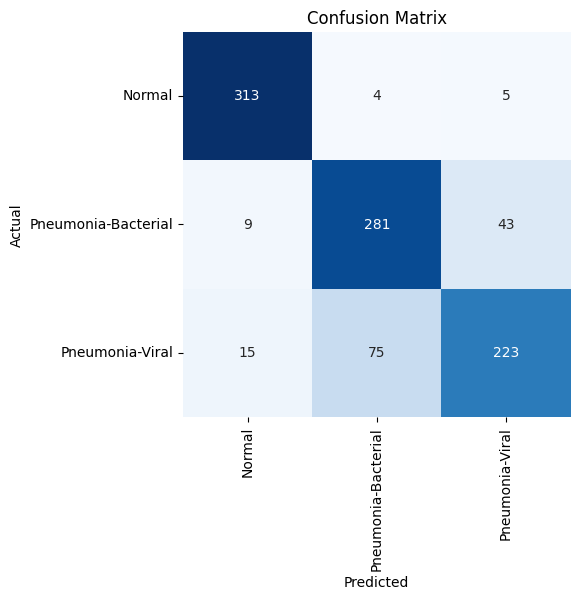

In [34]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(3) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(3) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [35]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                      precision    recall  f1-score   support

             Normal       0.93      0.97      0.95       322
Pneumonia-Bacterial       0.78      0.84      0.81       333
    Pneumonia-Viral       0.82      0.71      0.76       313

           accuracy                           0.84       968
          macro avg       0.84      0.84      0.84       968
       weighted avg       0.84      0.84      0.84       968



In [39]:
import numpy as np
from tensorflow.keras.preprocessing import image
image_path='/kaggle/input/3-classification-of-pneumonia/New classification/Pneumonia-Viral/Pneumonia-Viral (1007).jpg'
img = image.load_img(image_path, target_size=(224,224,3))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)
class_labels = train_images.class_indices
predicted_class_label = list(class_labels.keys())[predicted_class_index]

print('Predicted class:', predicted_class_label)

1/1 [==============================] - 0s 28ms/step
Predicted class: Pneumonia-Viral
